# Reproducing: Prophecy of loan approval by comparing Decision Tree with Logistic Regression, Random Forest, KNN for better Accuracy
This notebook mirrors the paper’s procedure:
- 10 randomized 80/20 train–test splits
- Models: Logistic Regression (LR), Decision Tree (DT), Random Forest (RF), KNN
- Metrics per run: **Accuracy** and the paper’s “Cross Validation” = **Precision** (TP/(TP+FP))
- Aggregate means/stdev


In [69]:
# Inputs
CSV_PATH = "loan_approval_dataset.csv"
TARGET_COL = " loan_status"     # binary target column name
POSITIVE_LABEL = " Approved"
TEST_SIZE = 0.2                # 80/20 split
N_REPEATS = 10                 # number of randomized runs
RANDOM_SEED = 42               # base seed

# Imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [71]:
## Load the data
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
df.head(10)


Shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
5,6,0,Graduate,Yes,4800000,13500000,10,319,6800000,8300000,13700000,5100000,Rejected
6,7,5,Graduate,No,8700000,33000000,4,678,22500000,14800000,29200000,4300000,Approved
7,8,2,Graduate,Yes,5700000,15000000,20,382,13200000,5700000,11800000,6000000,Rejected
8,9,0,Graduate,Yes,800000,2200000,20,782,1300000,800000,2800000,600000,Approved
9,10,5,Not Graduate,No,1100000,4300000,10,388,3200000,1400000,3300000,1600000,Rejected


## Basic checks on target and features:
Ensure the target exists, inspect class balance, and split features/target.

In [72]:
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found."

y_raw = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

# Drop the ID column so it doesn't leak information
X = X.drop(columns=['loan_id',' bank_asset_value'])

print("Features shape:", X.shape)
print("Target distribution:")
print(y_raw.value_counts(dropna=False))


Features shape: (4269, 10)
Target distribution:
 loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


## Convert the target to a 0/1 vector
Many metrics assume binary {0,1}. We treat POSITIVE_LABEL as 1.

In [73]:
def to_binary(y_series, positive_label):
    return (y_series == positive_label).astype(int)

y = to_binary(y_raw, POSITIVE_LABEL)
y.value_counts()


 loan_status
1    2656
0    1613
Name: count, dtype: int64

## Preprocessing: numeric vs categorical
- Impute numeric with median, standardize (helps LR/KNN).

- Impute categorical with most_frequent, one-hot encode.

In [74]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: [' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value']
Categorical columns: [' education', ' self_employed']


## Define the models

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [76]:
X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = preprocess.transform(X_test)


In [77]:
models = {
    "LR": LogisticRegression(
        penalty="l2", solver="lbfgs", max_iter=200
    ),
    "DT": DecisionTreeClassifier(
        criterion="gini", random_state=RANDOM_SEED
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=11
    )

}
models

for name, model in models.items():
    model.fit(X_train_processed, y_train)


In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

baseline_models = {
    "LR": LogisticRegression(penalty="l2", solver="lbfgs", max_iter=200),
    "DT": DecisionTreeClassifier(criterion="gini", random_state=RANDOM_SEED),
    "KNN": KNeighborsClassifier(n_neighbors=11)
}

lr_param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear"]

}

knn_param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan"]
}

dt_param_grid = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [None, 3, 5, 8, 12, 16],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10]
}

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

tuned_models = {
    "LR_Tuned": GridSearchCV(
        Pipeline([("preprocess", preprocess),
                  ("model", LogisticRegression(max_iter=1000))]),
        param_grid=lr_param_grid, scoring="accuracy", cv=5, n_jobs=-1
    ),

    "KNN_Tuned": GridSearchCV(
        Pipeline([("preprocess", preprocess),
                  ("model", KNeighborsClassifier())]),
        param_grid=knn_param_grid, scoring="accuracy", cv=5, n_jobs=-1
    ),

    "DT_Tuned": GridSearchCV(
        Pipeline([("preprocess", preprocess),
                  ("model", DecisionTreeClassifier(random_state=RANDOM_SEED))]),
        param_grid=dt_param_grid, scoring="accuracy", cv=5, n_jobs=-1
    )
}

all_models = {**baseline_models, **tuned_models}

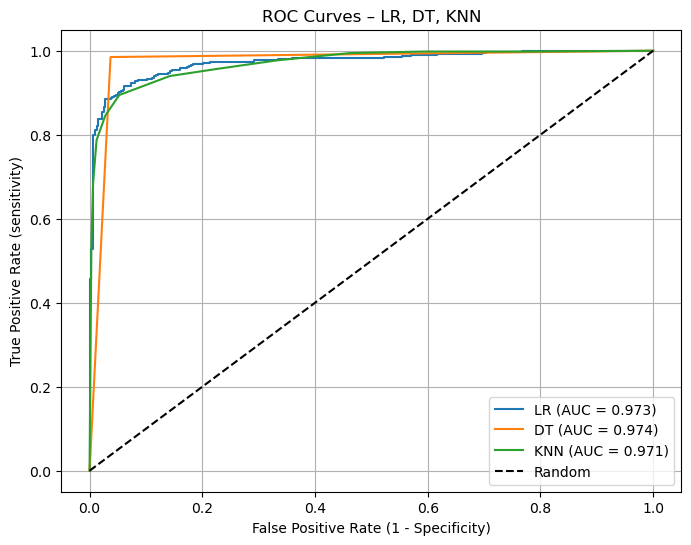

In [84]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

X_test_features = X_test_processed

plt.figure(figsize=(8, 6))

for name, model in models.items():

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_features)[:, 1]
    else:
        y_scores = model.decision_function(X_test_features)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")


plt.plot([0, 1], [0, 1], 'k--', label="Random")

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (sensitivity)")
plt.title("ROC Curves – LR, DT, KNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

X_test_features = X_test_processed  

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_features)

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_features)[:, 1]
    else:
        y_scores = model.decision_function(X_test_features)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_scores)
    })

results_df = pd.DataFrame(results).set_index("Model").round(4)
results_df


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Model,,,,,
LR,0.9169,0.9228,0.9454,0.9340,0.9732
DT,0.9766,0.9776,0.9849,0.9812,0.9739
KNN,0.9087,0.9156,0.9397,0.9275,0.9706


## Repeated randomized evaluation (10 runs):

The paper repeats 80/20 splits 10 times and reports metrics each run.
We compute:

- Accuracy (overall correctness)
- Precision (paper’s “cross validation”): TP/(TP+FP)

In [88]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

results = []

for run in range(N_REPEATS):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED + run, stratify=y
    )

    # manual preprocessing ONLY for baseline models
    X_train_processed = preprocess.fit_transform(X_train)
    X_test_processed  = preprocess.transform(X_test)

    for name, model in all_models.items():
        is_search = isinstance(model, GridSearchCV)

        # Fit
        if is_search:
            model.fit(X_train, y_train)
            final_model = model.best_estimator_
            X_test_for_pred = X_test
        else:
            model.fit(X_train_processed, y_train)
            final_model = model
            X_test_for_pred = X_test_processed

        # Predict + scores
        y_pred = final_model.predict(X_test_for_pred)
        y_scores = final_model.predict_proba(X_test_for_pred)[:, 1]

        results.append({
            "model": name,
            "run": run,
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "roc_auc": roc_auc_score(y_test, y_scores)
        })


C:\Users\Yael Sisniega\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\Yael Sisniega\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\Yael Sisniega\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## Aggregate results across runs
Report mean and standard deviation

In [89]:
results_df = pd.DataFrame(results)

summary = (
    results_df.groupby("model")
    .agg(
        mean_accuracy=("accuracy","mean"),
        std_accuracy=("accuracy","std"),
        mean_precision=("precision","mean"),
        mean_roc_auc=("roc_auc","mean")
    )
    .sort_values("mean_accuracy", ascending=False)
)

display(summary)


,mean_accuracy,std_accuracy,mean_precision,mean_roc_auc
model,,,,
DT_Tuned,0.980094,0.005464,0.984930,0.986105
DT,0.978806,0.005043,0.984891,0.978106
LR_Tuned,0.935246,0.005410,0.967255,0.965069
KNN_Tuned,0.921780,0.008689,0.935893,0.974893
LR,0.915340,0.005238,0.929999,0.968110
KNN,0.912763,0.009581,0.933278,0.969652


## Final comparison and concise report
Identify the top model by the paper’s main criterion (accuracy), and show its average precision as reported by them.

In [90]:
print("Per-iteration metrics (first 10 rows):")
display(results_df.head(10))

print("\nAggregated 10-run summary:")
display(summary)

# Identify the best-performing model by mean accuracy
best_model_name = summary.index[0]
best_row = summary.iloc[0]

print(
    f"\nBest model by mean accuracy (10 runs): {best_model_name} | "
    f"Mean Accuracy = {best_row['mean_accuracy']:.4f} | "
    f"Mean Test Precision = {best_row['mean_precision']:.4f} | "
    f"Mean ROC-AUC = {best_row['mean_roc_auc']:.4f}"
)


Per-iteration metrics (first 10 rows):


,model,run,accuracy,precision,roc_auc
0,LR,0,0.912178,0.917582,0.972877
1,DT,0,0.981265,0.981308,0.978870
2,KNN,0,0.918033,0.927644,0.971544
3,LR_Tuned,0,0.944965,0.968992,0.973850
4,KNN_Tuned,0,0.921546,0.932836,0.979086
5,DT_Tuned,0,0.982436,0.981343,0.982366
6,LR,1,0.911007,0.926829,0.965478
7,DT,1,0.974239,0.984762,0.974433
8,KNN,1,0.911007,0.938343,0.968002
9,LR_Tuned,1,0.927400,0.962525,0.961857



Aggregated 10-run summary:


,mean_accuracy,std_accuracy,mean_precision,mean_roc_auc
model,,,,
DT_Tuned,0.980094,0.005464,0.984930,0.986105
DT,0.978806,0.005043,0.984891,0.978106
LR_Tuned,0.935246,0.005410,0.967255,0.965069
KNN_Tuned,0.921780,0.008689,0.935893,0.974893
LR,0.915340,0.005238,0.929999,0.968110
KNN,0.912763,0.009581,0.933278,0.969652



Best model by mean accuracy (10 runs): DT_Tuned | Mean Accuracy = 0.9801 | Mean Test Precision = 0.9849 | Mean ROC-AUC = 0.9861


## Interpretation


After extending the baseline methodology through systematic hyperparameter tuning, the tuned Decision Tree model achieved the best overall performance on the loan approval dataset. Averaged across 10 randomized train–test splits, the optimized tree reached a mean accuracy of 0.9801, a mean precision of 0.9849, and a mean ROC-AUC of 0.9861. These results indicate that constraining the tree’s depth and minimum sample requirements significantly improved generalization by reducing overfitting while preserving the model’s ability to capture non-linear feature interactions. Compared to the baseline models, the tuned Decision Tree provides a strong balance between predictive performance, stability across runs, and interpretability, making it the most suitable model for this dataset.
